# Data Preprocessing

In [1]:
import csv
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

## Import training data

In [25]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

for line in lines:
    
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = './data/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image)
        
        correction = 0.2 # this is a parameter to tune
        if i == 0:
            steering_center = float(line[3])
            measurements.append(steering_center)
        elif i == 1:
            steering_left = steering_center + correction
            measurements.append(steering_left)
        else:
            steering_right = steering_center - correction
            measurements.append(steering_right)


In [ ]:
# sample visualization
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
len(images)

## Data augmentation

In [85]:
def preprocess_image(img):
    '''
    Method for preprocessing images: this method is the same used in drive.py, except this version uses
    BGR to YUV and drive.py uses RGB to YUV (due to using cv2 to read the image here, where drive.py images are 
    received in RGB)
    '''
    # original shape: 160x320x3, input shape for neural net: 66x200x3
    # crop image
    new_img = img[50:140,:,:]
    # scale to 66x200x3 (same as nVidia)
    new_img = cv2.resize(new_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space (as nVidia paper suggests)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

In [86]:
def randomise_image_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # brightness
    randomLight = 0.3 + np.random.rand() 
    hsv[:,:,2] =  hsv[:,:,2] * randomLight
    
    return cv2.cvtColor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2YUV)
#     return cv2.cvtColor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2YUV)

In [87]:
def jitter_image_rotation(image, steering):
    rows, cols, _ = image.shape
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    steering = steering + transX/transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return (image, steering)

## Use generators to load and preprocess data on the fly

In [88]:
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [89]:
def generator(samples, batch_size=64):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            
            for batch_sample in batch_samples:
                
                for idx in range(3):
                    name = './data/IMG/'+ batch_sample[idx].split('/')[-1]
                    image = cv2.imread(name)
                    
                    image = preprocess_image(image)

                    correction_left = 0.25 # this is a parameter to tune
                    correction_right = 0.25
                    steering_center = float(batch_sample[3])
                    images.append(image)

                    if idx == 0:
                        measurements.append(steering_center)
                    elif idx == 1:
                        steering_left = steering_center + correction_left
                        measurements.append(steering_left)
                    else:
                        steering_right = steering_center - correction_right
                        measurements.append(steering_right)
            
            # augment the data by flipping horizontally
            augmented_images, augmented_measurements = [], []

            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
    
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*(-1.0))
            
            # augment the data by randomize the brightness
            train_images, train_measurements = [], []

            for image, measurement in zip(augmented_images, augmented_measurements):    
                train_images.append(randomise_image_brightness(image))
                train_measurements.append(measurement)
                
                image_jitter, measurement_jitter = jitter_image_rotation(image, measurement)
                
                train_images.append(image_jitter)
                train_measurements.append(measurement_jitter)               
            # trim image to only see section with road
            X_train = np.array(train_images)
            y_train = np.array(train_measurements)
            
            yield shuffle(X_train, y_train)

## Training using Keras

In [90]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers.core import Dropout

ch, row, col = 3, 66, 200  # Trimmed image format

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001), activation = "relu"))
model.add(Dropout(0.3))

model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001), activation = "relu"))
model.add(Dropout(0.3))

model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001), activation = "relu"))
model.add(Dropout(0.3))

model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001), activation = "relu"))
model.add(Dropout(0.3))

model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001), activation = "relu"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(100, W_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(50, W_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(10, W_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(1))

In [91]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)

In [92]:
model.compile(loss = 'mse', optimizer=Adam(lr=1e-4))
history_object = model.fit_generator(train_generator, samples_per_epoch =
    12*len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = 12*len(validation_samples), 
    nb_epoch=20, verbose=1)

Epoch 1/20
77136/77136 [==============================] - 84s - loss: 0.5224 - val_loss: 0.4902
Epoch 2/20
77136/77136 [==============================] - 83s - loss: 0.4534 - val_loss: 0.4340
Epoch 3/20
77136/77136 [==============================] - 83s - loss: 0.3950 - val_loss: 0.3827
Epoch 4/20
77136/77136 [==============================] - 83s - loss: 0.3419 - val_loss: 0.3329
Epoch 5/20
77136/77136 [==============================] - 84s - loss: 0.2954 - val_loss: 0.2893
Epoch 6/20
77136/77136 [==============================] - 83s - loss: 0.2550 - val_loss: 0.2467
Epoch 7/20
77136/77136 [==============================] - 83s - loss: 0.2216 - val_loss: 0.2151
Epoch 8/20
77136/77136 [==============================] - 83s - loss: 0.1927 - val_loss: 0.1897
Epoch 9/20
77136/77136 [==============================] - 83s - loss: 0.1692 - val_loss: 0.1628
Epoch 10/20
77136/77136 [==============================] - 84s - loss: 0.1495 - val_loss: 0.1430
Epoch 11/20
77136/77136 [==============

dict_keys(['loss', 'val_loss'])


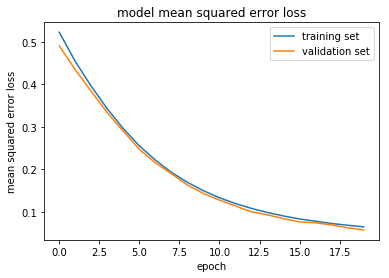

In [93]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [94]:
model.save('model0523v9.h5')